In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dir_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

os.chdir(dir_path)

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def generate_perpendicular_grids(xgr, zgr, resolution=30, max_depth=3):
    """This function takes an xgrid and a zgrid, as well as a resolution and maximum depth, and returns a (temperature) grid perpendicular to the existing x and z-grid.
    ----------
    xgr: array
        1D array of x-values
    zgr: array
        1D array of z-values
    resolution: integer (default: 30)
        number of desired grid points in the 1D models
    max_depth: float (default: 3)
        maximum depth to be modelled
    ---------Returns----------
    Returns: x_matrix, z_matrix
    
    x_matrix: array
        2D array of x-values. Each row contains the x-values for a 1D model
    z_matrix: array
        2D array of z-values. Each row contains the z-values for a 1D model
    """
    temp_depth_grid = np.linspace(0, max_depth, resolution)
    initial_temp = np.linspace(-5, 5, resolution)

    thermal_matrix = np.zeros((xgr.shape[0], temp_depth_grid.shape[0]))

    for i in range(len(thermal_matrix)):
        thermal_matrix[i,:] = initial_temp
        
    gradient = np.gradient(zgr, xgr)

    orientation = np.arctan(gradient) - 0.5 * np.pi
        
    x_matrix = np.tile(xgr, (len(temp_depth_grid), 1)).T + np.outer(np.cos(orientation), temp_depth_grid)
    z_matrix = np.tile(zgr, (len(temp_depth_grid), 1)).T + np.outer(np.sin(orientation), temp_depth_grid)
    
    return x_matrix, z_matrix

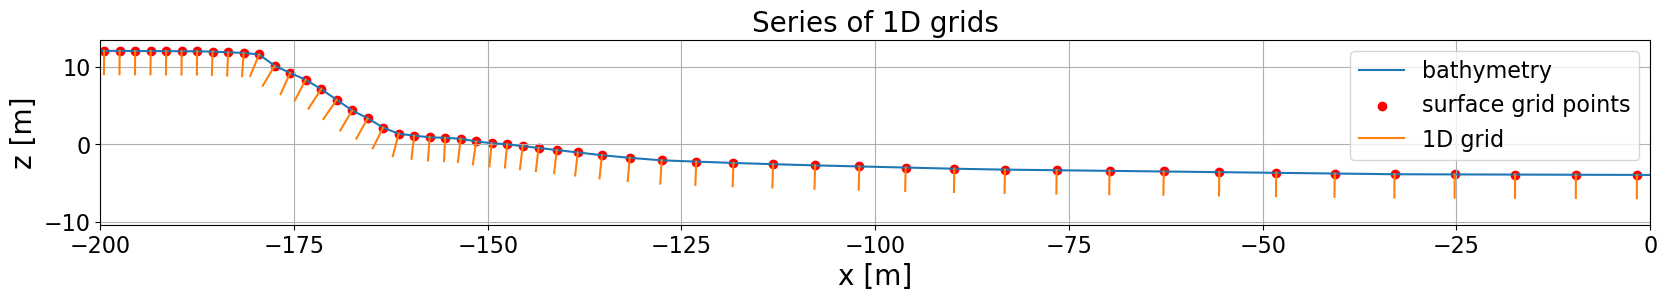

In [5]:
from xbTools.grid.creation import xgrid, ygrid

bathy_grid = np.loadtxt(Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/thermo-morphological-model/database/initial_conditions/x.grd"))
bathy_initial = np.loadtxt(Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/thermo-morphological-model/database/initial_conditions/bed.dep"))

xgr, zgr = xgrid(bathy_grid, bathy_initial, dxmin=2)

zgr = np.interp(xgr, bathy_grid, bathy_initial)

abs_x1, abs_z2 = generate_perpendicular_grids(xgr, zgr)


fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(xgr, zgr, label='bathymetry')
ax.scatter(xgr, zgr, color='r', label='surface grid points')

label_set = False

for x_coords, z_coords in zip(abs_x1, abs_z2):
    if not label_set:
        ax.plot(x_coords, z_coords, color='C1', label='1D grid')
        # ax.scatter(x_coords, z_coords, color='k', label='1D grid points')
        
        label_set = True
    else:
        ax.plot(x_coords, z_coords, color='C1')
        # ax.scatter(x_coords, z_coords, color='k')

ax.set_aspect('equal')
ax.set_xlim((-200, -0))

ax.legend()

ax.grid()

ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')

ax.set_title('Series of 1D grids')

figname = 'thermal_grid.png'

plt.savefig(figname, bbox_inches='tight', facecolor='white', transparent=False)


Assuming that the thaw interface is at half the modelling length.

In [6]:
xgr, zgr = xgrid(bathy_grid, bathy_initial, dxmin=2)

zgr = np.interp(xgr, bathy_grid, bathy_initial)

abs_x1, abs_z2 = generate_perpendicular_grids(xgr, zgr)

thaw_x = abs_x1[:, abs_x1.shape[1]//2]
thaw_z = abs_z2[:, abs_x1.shape[1]//2]

sort_i = np.argsort(thaw_x)

thaw_x = thaw_x[sort_i]
thaw_z = thaw_z[sort_i]

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(xgr, zgr, label='bathymetry')
ax.scatter(xgr, zgr, color='r', label='surface grid points')

label_set = False

for x_coords, z_coords in zip(abs_x1, abs_z2):
    if not label_set:
        ax.plot(x_coords, z_coords, color='C1', label='1D grid')
        # ax.scatter(x_coords, z_coords, color='k', label='1D grid points')

        label_set = True
    else:
        ax.plot(x_coords, z_coords, color='C1')
        # ax.scatter(x_coords, z_coords, color='k')
        

plt.vlines(x=xgr, ymin=zgr-2, ymax=zgr, linestyle='dashed', color='k', label='thaw depth')
   
ax.scatter(thaw_x, thaw_z, label='thaw point', color='k')
ax.plot(thaw_x, thaw_z, label='thaw_interface', color='k')
        
ax.set_aspect('equal')
ax.set_xlim((-180, -140))

ax.legend()

ax.grid()

ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')

ax.set_title('Series of 1D grids')

figname = 'thaw_depth_grid.png'

plt.savefig(figname, bbox_inches='tight', facecolor='white', transparent=False)

plt.close()